# Phyloseq operations

Phyloseq is a package made for organizing and working with microbiome data in R. With the phyloseq package we can have all our microbiome amplicon sequence data in a single R object. With functions from the phyloseq package, most common operations for preparing data for analysis is possible with few simple commands.

This document is an overview on how phyloseq objects are organized and how they can be changed.

The paper presenting phyloseq:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061217

A comprehensive documetation of the phyloseq package:
https://joey711.github.io/phyloseq/

In [1]:
# Load package and phyloseq object
library(phyloseq)
load("../data/physeq.RData")

# Subset samples<a class="anchor" id="subdata"></a>

We can subset the samples with the subset_samples function. We can subset based on any column in the sample_data:

In [2]:
sample_variables(phy)

[1] "Patient"  "Time"     "Delivery"

First argument to the subset_samples() function is the phyloseq object we want to subset.
In the second argument we tell the function how to subset.
Here we get the 1 week (1w) samples (always use two = signs)

In [3]:
phy_1w <- subset_samples(phy, Time == "1w")

Now we only have the 50 1 week samples in phy_1w

In [4]:
phy_1w

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

We can also subset both 1 week and 1 month samples:

In [5]:
phy_1w1m <- subset_samples(phy, Time %in% c("1w", "1m"))
phy_1w1m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

We can also subset on different variables at the same time. Here we only take 1 week samples from children born by C-section (Use & for *and*, use | for *or*):

In [6]:
phy_1wS <- subset_samples(phy, Time == "1w" & Delivery == "Sectio")
phy_1wS

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

### Handling NAs
If you have NAs, you will often encounter problems when subsetting, so it's often a good idea to remove those with NAs before subsetting further. Below we assume that for some of the children the delivery mode is unknown (NA):

In [7]:
phy_nona <- subset_samples(phy, !is.na(Delivery))
phy_sectio <- subset_samples(phy_nona, Delivery == "Sectio")

This can also be done in one line:

In [9]:
phy_sectio <- subset_samples(phy, !is.na(Delivery) & Delivery == "Sectio")

### Checking your output
It's always a good idea to check that you get the expected output. We can use the table() function to count the number of samples in each group. First look at the original phyloseq:

In [10]:
with(sample_data(phy), table(Time, Delivery))

    Delivery
Time Sectio Vaginal
  1m     25      25
  1w     25      25
  1y     25      25

Let's look at the sectio subset made above, and ensure that we only have sectio samples:

In [11]:
with(sample_data(phy_sectio), table(Time, Delivery))

    Delivery
Time Sectio
  1m     25
  1w     25
  1y     25

# Prune samples<a class="anchor" id="prunedata"></a>

We can also subset samples based on how many reads each sample have. 
sample_sums(phy) outputs the number of reads for each sample. Here we subset samples that have more than 5000 reads, and we can see that 10 samples have been thrown away:

In [12]:
phy_5k <- prune_samples(sample_sums(phy) > 5000, phy)
phy_5k

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 140 samples ]
sample_data() Sample Data:       [ 140 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

# Subset taxa<a class="anchor" id="subtax"></a>

In the same way as we can subset samples, we can also subset taxa. E.g. only Firmicutes:

In [13]:
phy_1wfirms <- subset_taxa(phy_1w, Phylum == "Firmicutes")

We can subset based on all the different taxonomic ranks:

In [14]:
rank_names(phy)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

Notice that we ran the above subset command on the phy_1w object that we created earlier.
Now we only have 1 week samples and only Firmicutes ASVs.
We can chain together all the different subsetting commands together to get exactly the subset of samples and taxa we want.

# Prune taxa<a class="anchor" id="prunetax"></a>

We can also prune taxa by how abundant they are.
A convenient function to do this is ps_prune from the MicEco package.
Load the package first:

In [15]:
library(MicEco)

We can filter low abundant taxa based on three criteria:
* They should be present in a minimum amount of samples (min.samples)
* They should have a minimum amount of reads (min.reads)
* They should have a minimum average relative abundance (min.abundance)

You don't have to use all three criteria.
The filtered taxa are grouped in a new taxa called "Others".

Below we only want taxa that are:
* at least present in 5 samples
* at least have a total of 10 reads

In [16]:
phy_abund <- ps_prune(phy, min.samples = 5, min.reads = 10)
phy_abund

985 features grouped as 'Others' in the output



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 326 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 326 taxa by 7 taxonomic ranks ]

**Note on pruning taxa:** There are, unfortunately, no standards on how to set the thresholds when pruning low abundant ASVs. It is usually done before differential abundance analyses to lower the number of features tested. The thresholds depends on the dataset and the hypotheses you want to test. Pruning low abundant taxa is usually not done prior to alpha or beta-diversity analyses.

# Transform abundance<a class="anchor" id="trans"></a>

Amplicon data is relative data

Most of the time, we therefore want to transform or normalize the raw read counts.
We can transform abundances with transform_sample_counts().
We have to give it a function which tells it how to transform the abundance for each sample.
The most simple way to do this is relative abundance (everything sums to one):

In [17]:
phy_rel <- transform_sample_counts(phy, function(x) x/sum(x))

Let's look at the first 5 ASVs and 10 first samples. Now the otu_table contains relative abundances:

In [18]:
otu_table(phy_rel)[1:5, 1:10]

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
dc467f0f8b8aa389aa106d751bb9a569,0.000000000,0,0,0.000000000,0,0,0,0,0,0
c387bc64fb22cd96d2b79dbfa932ce1e,0.000000000,0,0,0.000000000,0,0,0,0,0,0
42a23e6f4764f572f4d7c6d8e08769c3,0.000000000,0,0,0.000000000,0,0,0,0,0,0
2ea17744c7eeab459b7f41d4f9e22894,0.001002609,0,0,0.007007981,0,0,0,0,0,0
332ef16f5660bfe8ecaabda3404fc08b,0.000000000,0,0,0.000000000,0,0,0,0,0,0


and the sum for each sample is 1 (100%):

In [19]:
sample_sums(phy_rel)

S1   S2   S3   S4   S5   S6   S7   S8   S9  S10  S11  S12  S13  S14  S15  S16 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S17  S18  S19  S20  S21  S22  S23  S24  S25  S26  S27  S28  S29  S30  S31  S32 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S33  S34  S35  S36  S37  S38  S39  S40  S41  S42  S43  S44  S45  S46  S47  S48 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S49  S50  S51  S52  S53  S54  S55  S56  S57  S58  S59  S60  S61  S62  S63  S64 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S65  S66  S67  S68  S69  S70  S71  S72  S73  S74  S75  S76  S77  S78  S79  S80 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S81  S82  S83  S84  S85  S86  S87  S88  S89  S90  S91  S92  S93  S94  S95  S96 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 S97  S98  S99 S100 S101 S102 S103 S104 S105 S106 S107 S108 S109 S110 S111 S112 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
S113 S114 S115 S116 S117 S118 S119 S120 S121 S122 S123 S124 S125 S126 S127 S128 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
S129 S130 S131 S132 S133 S134 S135 S136 S137 S138 S139 S140 S141 S142 S143 S144 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
S145 S146 S147 S148 S149 S150 
   1    1    1    1    1    1

# New variables<a class="anchor" id="var"></a>
We often want to make new variables based on a single or a combination of existing variables. We might want to force a continuous variable into a binary, such as low/high BMI. Or combine variables, such as making a "Pet" variable if either the "Cat" or "Dog" variable is TRUE. How you "code" you variables depend on the hypothesis. Below are some examples of making new variables.

There are three steps in making a new variable:
* Extract sample_data to a data.frame
* Add the new variable(s)
* Put the new sample_data back into the phyloseq object

In [20]:
# First step:
metadata <- data.frame(sample_data(phy))

#### Combine levels of the same factor

In [21]:
# Here we make a new Time variable where we combine the 1w and 1m samples to a level we call "Early"
# ifelse takes three arguments: A logical, what to return if the logical is TRUE, what to return if the logical is FALSE
metadata$Time_new <- ifelse(metadata$Time == "1y", "Late", "Early")

#### Combine levels of different factors

In [22]:
# Here we combine the Time and Delivery variable to make a new variable.
metadata$New_variable <- ifelse(metadata$Time == "1y" & metadata$Delivery == "Sectio", "1y sectio", "Not 1y sectio")

#### Continuous variable to binary variable

In [23]:
# As there are no continuous variables in this example, I use the total read counts instead
metadata$Reads_binary <- ifelse(sample_sums(phy) > 10000, "High", "Low")

#### Continuous variable to categorical variable

In [25]:
# Here we nest the ifelse() functions, so if the first logical is TRUE, then it is run through another ifelse()
metadata$Reads_cat <- ifelse(sample_sums(phy) > 10000, ifelse(sample_sums(phy) > 20000, "Very high", "High"), "Low")

### Put back into phyloseq

In [26]:
sample_data(phy) <- sample_data(metadata)

# Tax agglomoration<a class="anchor" id="agg"></a>

It is often necessary to group counts of ASVs according to higher taxonomic levels.
E.g. if we want to know how abundant different genera are, or we want to plot the most abundant phyla.
We use the tax_glom function to do this

Here we agglomorate to Phylum level:

In [27]:
phy_phylum <- tax_glom(phy, "Phylum")
phy_phylum

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 17 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 17 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 17 tips and 16 internal nodes ]
refseq()      DNAStringSet:      [ 17 reference sequences ]

We see in the output that we have 17 taxa. This is because we have 17 different phyla.
Let's see how the otu_table looks like (only 10 first samples):

In [28]:
otu_table(phy_phylum)[, 1:10]

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
2ea17744c7eeab459b7f41d4f9e22894,83,37,0,468,0,0,0,0,0,0
e5199a623272b9b25c65f0455a1cd77b,0,0,0,0,0,0,0,0,0,0
4c304a27bc0520a7c398410713645502,0,0,0,0,0,0,0,0,0,0
6ec6d03fbef9f16e3581ccdc60e7d266,10687,24637,61061,41594,483,13500,2625,12337,7375,16225
7e8a6b8b1cad81e2fb27e397921a3c3b,0,0,0,0,0,0,0,0,0,0
7c928c5109b32c792d73dce9122b80a9,0,0,0,0,0,0,0,0,0,0
8600bbb0e5ffe0a260abd39547d07c68,0,0,0,0,0,0,0,0,0,0
b2495dec275b068c7545b642c4322cd7,0,0,0,0,0,0,0,0,0,0
0eca810e771f78df0bf7f7f92dc873f0,0,0,0,0,0,0,0,0,0,0
98ca3e41d8d589d9d94aad956b84e054,0,0,0,0,0,0,0,0,0,270


**Note:** The ASVs are not the same as before. You can see what the new "Phylum-ASVs" correspond to in the tax_table:

In [29]:
tax_table(phy_phylum)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
2ea17744c7eeab459b7f41d4f9e22894,Bacteria,Fusobacteriota,NA,NA,NA,NA,NA
e5199a623272b9b25c65f0455a1cd77b,Bacteria,Deinococcota,NA,NA,NA,NA,NA
4c304a27bc0520a7c398410713645502,Bacteria,Cyanobacteriota,NA,NA,NA,NA,NA
6ec6d03fbef9f16e3581ccdc60e7d266,Bacteria,Actinobacteriota,NA,NA,NA,NA,NA
7e8a6b8b1cad81e2fb27e397921a3c3b,Bacteria,Myxococcota,NA,NA,NA,NA,NA
7c928c5109b32c792d73dce9122b80a9,Bacteria,Chloroflexota,NA,NA,NA,NA,NA
8600bbb0e5ffe0a260abd39547d07c68,Bacteria,Acidobacteriota,NA,NA,NA,NA,NA
b2495dec275b068c7545b642c4322cd7,Bacteria,Planctomycetota,NA,NA,NA,NA,NA
0eca810e771f78df0bf7f7f92dc873f0,Bacteria,Patescibacteria,NA,NA,NA,NA,NA
98ca3e41d8d589d9d94aad956b84e054,Bacteria,Desulfobacterota,NA,NA,NA,NA,NA


#  Plotting abundances<a class="anchor" id="plot"></a>
Let's put together some different functions to plot the most abundant families in the 1 week samples

Agglomorate to familes:

In [30]:
phy_fam <- tax_glom(phy_1w, "Family")

Transform to relative abundance:

In [31]:
phy_fam_rel <- transform_sample_counts(phy_fam, function(x) x/sum(x))

Filter low abundant:

In [32]:
phy_fam_rel_abund <- ps_prune(phy_fam_rel, min.abundance = 0.03)

113 features grouped as 'Others' in the output



We can transform the whole phyloseq object into a data.frame useful for plotting:

In [33]:
phy_df <- psmelt(phy_fam_rel_abund)

### Plot bar chart

In [34]:
library(ggplot2)

* geom_bar makes a barchart
* fill tells ggplot how to color the bars
* All the filtered taxa are grouped as NA

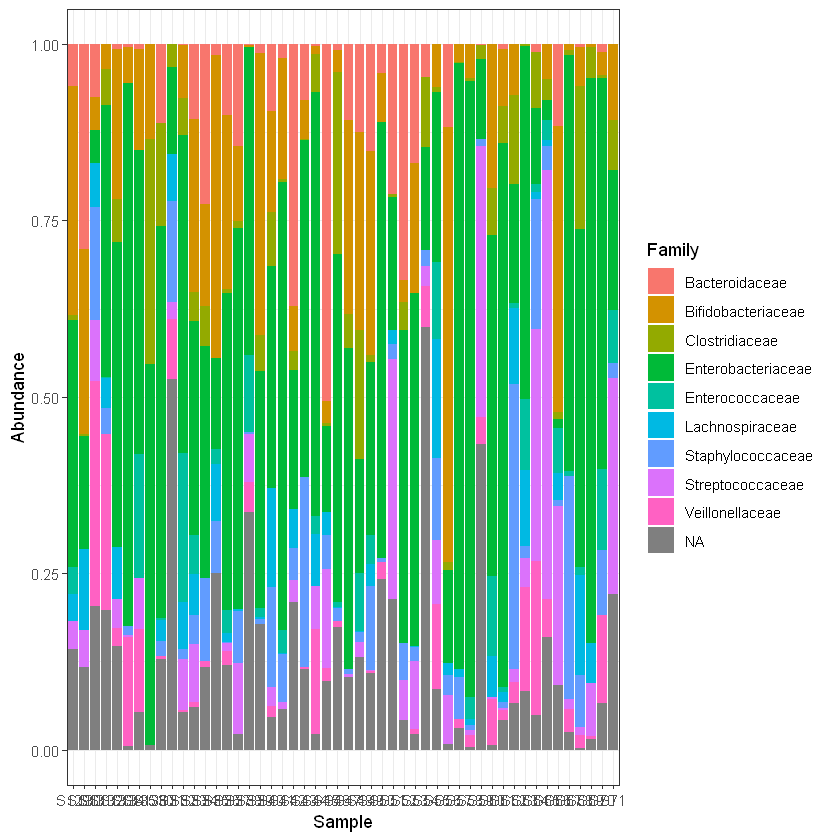

In [35]:
p <- ggplot(phy_df, aes(x = Sample, y = Abundance, fill = Family)) +
  theme_bw() +
  geom_bar(stat = "identity")
p

We can use facet's to split the plot depending on Delivery mode. And we angle the x labels and make them smaller.

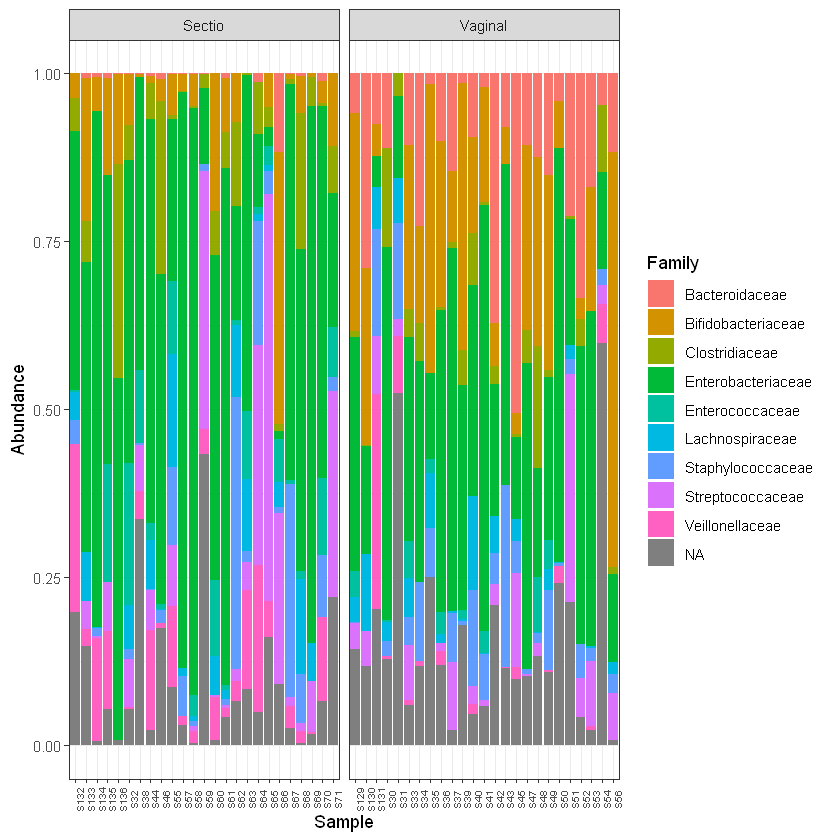

In [36]:
p <- ggplot(phy_df, aes(x = Sample, y = Abundance, fill = Family)) +
  theme_bw() +
  geom_bar(stat = "identity") +
  facet_grid(~ Delivery, space = "free", scales = "free") +
  theme(axis.text.x = element_text(angle=90, size=6))
p